In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

%load_ext autoreload
%autoreload 2

import numpy as np
from matplotlib import pyplot as plt
import scipy
from scipy import interpolate 

import sympy

import surfinBH

## Testing surfinBH

In [82]:
#Pick the fit
fitOpt = list(surfinBH.fits_collection.keys())
print(fitOpt)

[surfinBH.fits_collection[fit].desc for fit in fitOpt]

['NRSur3dq8Remnant', 'surfinBH7dq2', 'NRSur7dq4Remnant']


['Fits for remnant mass, spin and kick veclocity for nonprecessing BBH systems. This model was called surfinBH3dq8 in the paper.',
 'Fits for remnant mass, spin and kick veclocity for generically precessing BBH systems.',
 'Fits for remnant mass, spin and kick veclocity for generically precessing BBH systems up to mass ratio 4.']

In [13]:
fit = surfinBH.LoadFits('NRSur7dq4Remnant')
help(fit)

Loaded NRSur7dq4Remnant fit.
Help on Fit7dq4 in module surfinBH._fit_evaluators.fit_7dq4 object:

class Fit7dq4(surfinBH.surfinBH.SurFinBH)
 |  Fit7dq4(name, load_nrsur=False)
 |  
 |  A class for the NRSur7dq4Remnant model presented in Varma et al.,
 |  arxiv:1905.09300, hereafter referred to as THE PAPER.
 |  
 |  This model predicts the final mass mf, final spin vector
 |  chif and final kick velocity vector vf, for the remnants of precessing
 |  binary black hole systems.  The fits are done using Gaussian Process
 |  Regression (GPR) and also provide an error estimate along with the fit
 |  value.
 |  
 |  This model has been trained in the parameter space:
 |      q <= 4, |chiA| <= 0.8, |chiB| <= 0.8
 |  
 |  However, it extrapolates reasonably to:
 |      q <= 6, |chiA| <= 1, |chiB| <= 1
 |  
 |  =========================================================================
 |  Usage:
 |  
 |  import surfinBH
 |  
 |  # Load the fit
 |  fit = surfinBH.LoadFits('NRSur7dq4Remnant')
 |  

## Turning a PDF into an easy to sample random variable transform
#### Inverse transform sampling

1.00000000000000


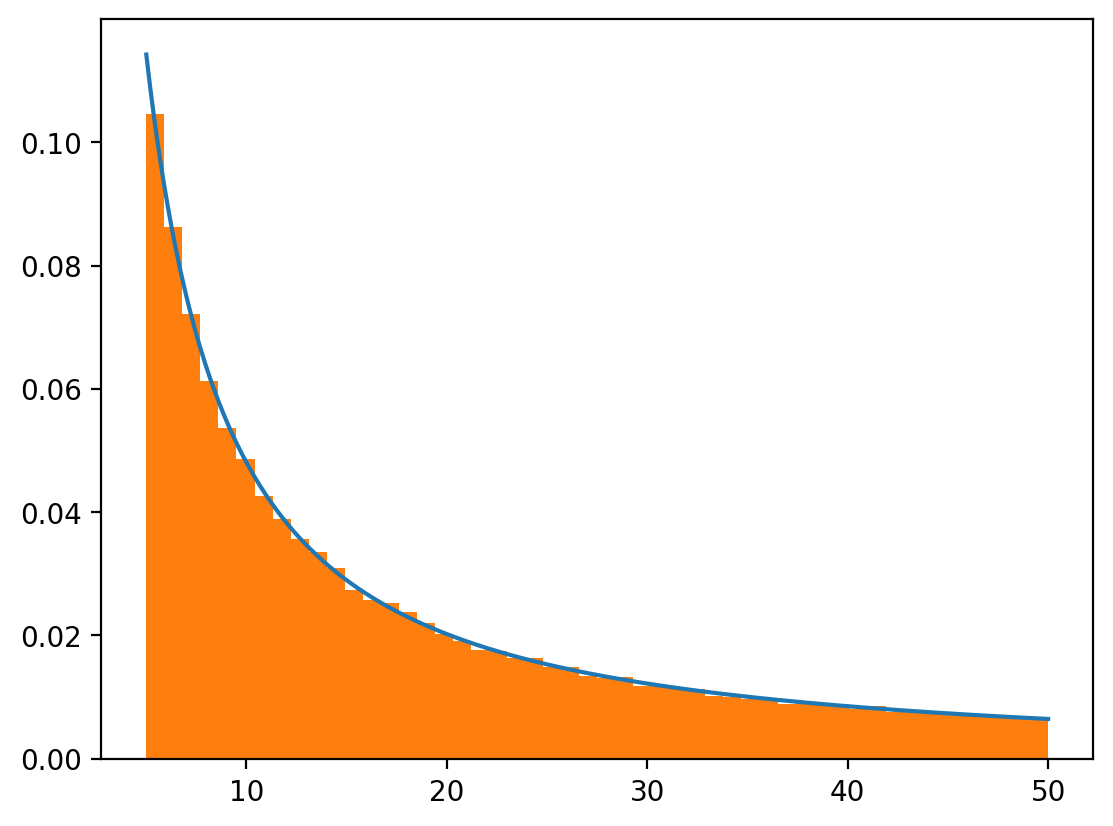

In [81]:
m = sympy.Symbol('m')
p = sympy.Symbol('p')
func = m**(-1.25)
norm = sympy.integrate(func, (m, 5, 50))
pdf = (1/norm)*m**(-1.25)


cdf = sympy.integrate(pdf,(m,5,m))

quantile = sympy.solvers.solve(cdf-p,m)

pdf = sympy.lambdify(m,pdf)
cdf = sympy.lambdify(m,cdf)
quantile = sympy.lambdify(p,quantile)

plt.plot(np.linspace(5,50,1000),pdf(np.linspace(5,50,1000)))
#plt.plot(np.linspace(5,50,1000),cdf(np.linspace(5,50,1000)))

u = np.random.random(100000)
mdist = quantile(u)
plt.hist(mdist,bins=50,density=True)
plt.show()



1.0


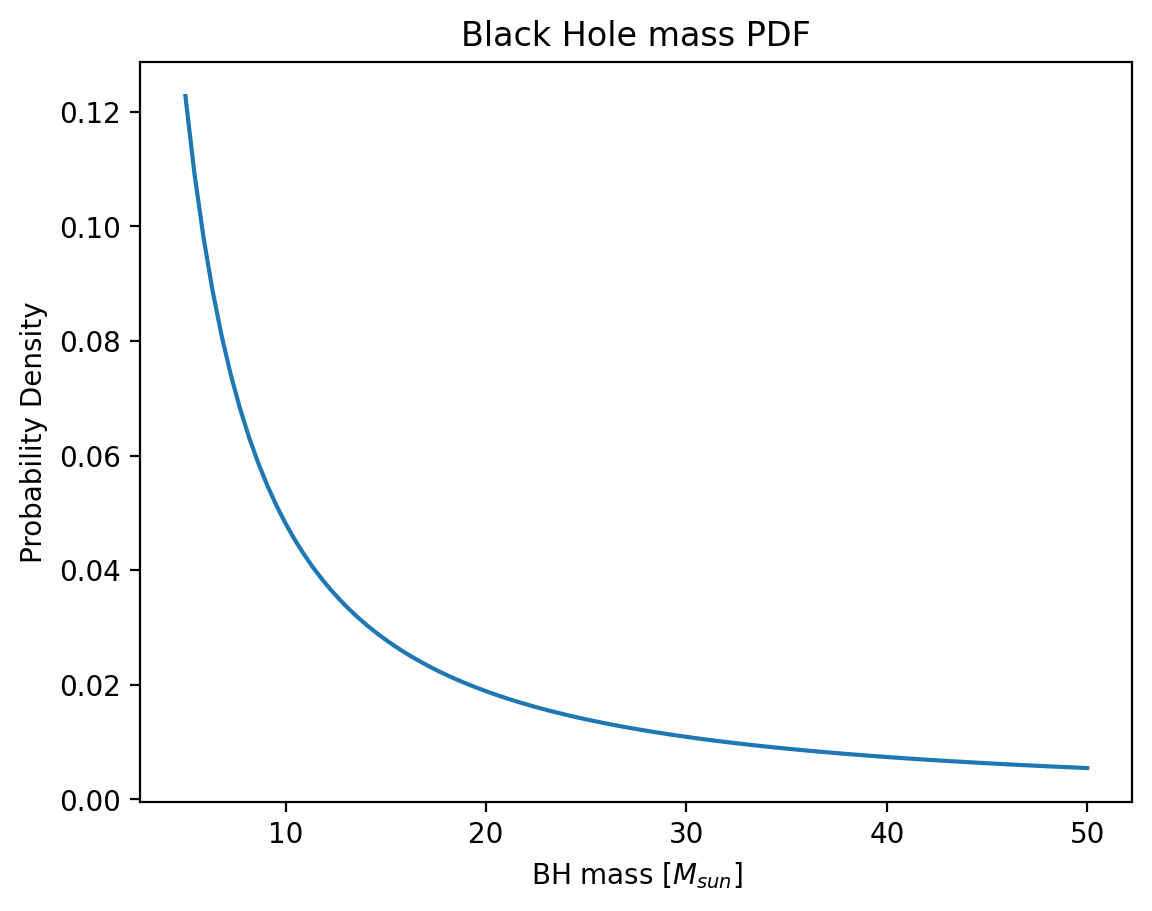

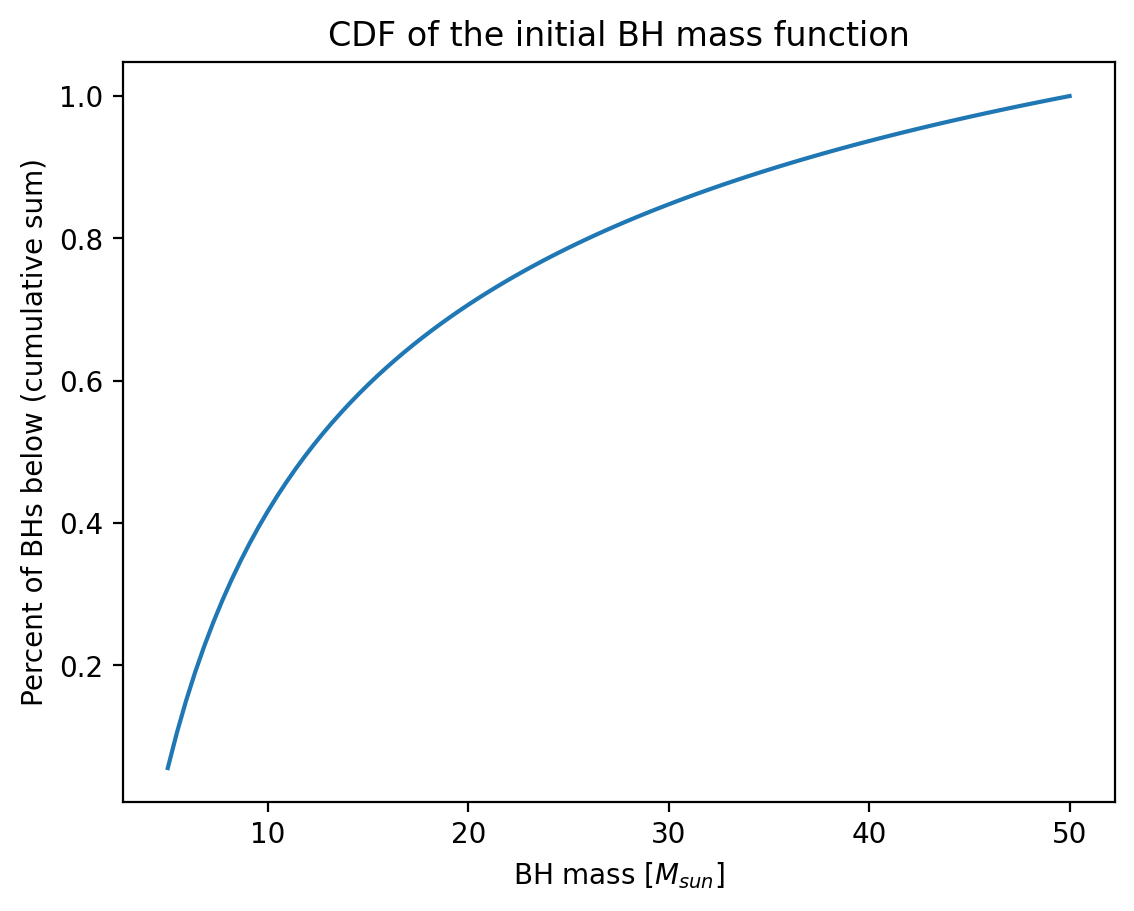

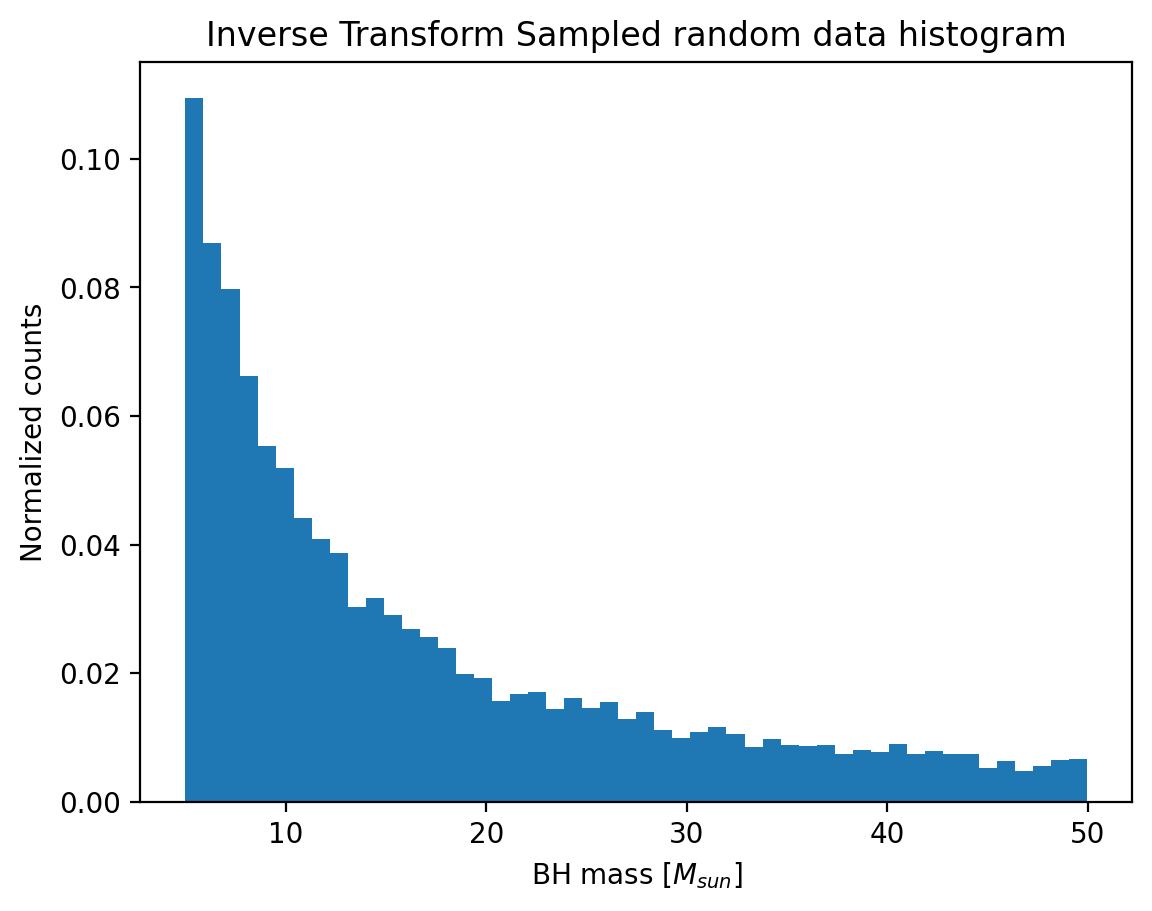

In [60]:
mdist = np.linspace(5,50,100)
dm = mdist[1]-mdist[0]

#Use initial mass function (integral form) 
#to get PDF of BH masses
ndist = mdist**-1.35
ndist = ndist/sum(ndist*dm)
print(sum(ndist*dm))

plt.title('Black Hole mass PDF')
plt.plot(mdist,ndist)
plt.xlabel('BH mass [$M_{sun}$]')
plt.ylabel('Probability Density')
plt.show()


#Turn this into a CDF
cdf = np.cumsum(ndist)/np.sum(ndist)
plt.title('CDF of the initial BH mass function')
plt.plot(mdist,cdf)
plt.xlabel('BH mass [$M_{sun}$]')
plt.ylabel('Percent of BHs below (cumulative sum)')
plt.show()

#Use inverse transform sampling, get a weighted distribution
#from a uniform distribution
invTranSamp = interpolate.interp1d(cdf, mdist)

u = np.random.uniform(min(cdf),max(cdf), 10000) 
sampled_m = invTranSamp(u)

plt.title('Inverse Transform Sampled random data histogram')
plt.hist(sampled_m, bins=50, density=True)
plt.xlabel('BH mass [$M_{sun}$]')
plt.ylabel('Normalized counts')
plt.show()

## Black hole object making!

In [40]:
import numpy as np
import sympy
import surfinBH

class BlackHole:
    '''The Black hole object, used to keep track of their parameters'''
    def __init__(self,mass,spin,velocity,time,bh1=None,bh2=None):
        '''Creating a new Black hole object'''
        
        # Need to keep track of formation parameters and time evolved
        self.m = mass
        
        self.s = spin
        #self.s_i = spin #Does spin evolve over time?
        
        self.v = velocity
        self.v_i = velocity
        
        self.t = time
        self.t_i = time
        
        self.parents = [bh1,bh2]
            
    
    def timeEvolve(self,v_thresh=1):
        #Use dynamical friction to find timescale
        #v_thresh is the max speed we allow collisions
        evolveT = 10
        self.t += evolveT
        self.v = v_thresh
        
    def isEjected(self,v_esc):
        #v_esc is the escape velocity of the cluster from the center
        if v_i > v_esc:
            self.bound = False
        else:
            self.bound = True
        
        return self.bound
        
class GC_simulation:
    ''' '''
    
    def __init__(self,GC_mass,GC_radius):
        ''' '''
        self.imf_alpha = 2.35
        self.m_bh_star_min = 10 #In solar masses
        self.bh_mass_fraction = 0.5 #Half mass in BH
        
        self.m_star_min = 0.8
        self.m_star_max = 100
        
        self.spin_variance = 1
        
        self.gc_mass = GC_mass #GC_mass must be in solar masses
        Nbh = self._calculateNbh()
        self._setup_rand_mass()
        
        
    
    def _calculateNbh(self):
        '''Calculate number of BHs given a GC mass
        *Uses Salpeter IMF'''
        
        #Need to find normalizing constant
        m = sympy.Symbol('m')
        func = m**(-(self.imf_alpha-1))
        a = self.gc_mass/sympy.integrate(func,(m,self.m_star_min,self.m_star_max))
        
        #Now use in number integral
        func2 = a*m**(-self.imf_alpha) 
        Nbh = sympy.integrate(func2,(m,self.m_bh_star_min,self.m_star_max))
        return int(Nbh)
    
    def _setup_rand_mass(self):
        '''sets up the random mass generator. Uses inverse transform sampling'''
        
        m = sympy.Symbol('m')
        p = sympy.Symbol('p')
        func = m**(-1.25)
        
        min_bh_mass = self.bh_mass_fraction*self.m_bh_star_min
        max_bh_mass = self.bh_mass_fraction*self.m_star_max
        norm = sympy.integrate(func, (m, min_bh_mass, max_bh_mass))
        
        pdf = (1/norm)*m**(-1.25)
        cdf = sympy.integrate(pdf,(m,5,m))

        quantile = sympy.solvers.solve(cdf-p,m)

        quantile = sympy.lambdify(p,quantile)
        
        self._mass_transform = quantile
        
    def random_mass(self,size=1,seed=None):
        if seed!=None:
            rng = np.random.default_rng(seed)
            return self._mass_transform(rng.random(size))[0]
        else:
            return self._mass_transform(np.random.random(size))[0]
    
    def random_spin(self,size=1,seed=None):
        '''Random spin generator. Uses a multidimensional gaussian with spin_variance'''
        #Randomly pick a spin magnitude, then randomly pick a direction
        if seed!=None:
            rng = np.random.default_rng(seed+1212)
            
            mags = rng.normal(loc=0,scale=np.sqrt(self.spin_variance),size=size)
            phi = rng.random(size)*2*np.pi
            theta = np.arcsin(rng.random(size))
        else:
            mags = np.random.normal(loc=0,scale=np.sqrt(self.spin_variance),size=size)
            phi = np.random.random(size)*2*np.pi
            theta = np.arcsin(np.random.random(size))
            
        return mags,phi,theta
    
        
test = GC_simulation(1e6,0)
test.random_mass(size=10,seed=1)
print(test.random_spin(size=10,seed=1))

(array([-0.81116619, -0.65241584,  0.49930731, -1.36523122,  0.04017388,
       -0.10473247, -1.11293677, -0.66019721, -0.74415942,  0.06673165]), array([0.26881939, 0.2149121 , 0.82218226, 1.4749341 , 4.60207791,
       3.08354605, 0.10197811, 4.65024753, 0.61450558, 3.43662496]), array([0.81851526, 1.08934093, 0.99079208, 0.21288301, 1.13822291,
       0.17096581, 0.6418196 , 0.33671249, 1.13479505, 0.83947038]))
